In [1]:
import tushare as ts
import time
import datetime
import sys
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
sys.path.append('../Codes')
import DataProcessor as DP
from DataProcessor import centralize
from DataProcessor import standardize
from DataProcessor import standardize_industry
from DataProcessor import get_industrys
from DataProcessor import get_all_industrys
from DataProcessor import get_stock_daily_data
from DataProcessor import get_stock_money_data
from DataProcessor import get_index_data

In [2]:
pro = ts.pro_api()

In [3]:
#获取行业分类
industrys = DP.get_all_industrys()

In [243]:
industry = ['801150.SI']

#取行业内股票数据
data = DP.get_stock_daily_data(industrys=industrys,
                               industry=industry,
                         fields=['open',
                                 'high',
                                 'low',
                                 'close',
                                 'adj_factor',
                                 'turnover_rate_f',
                                 'pe_ttm',
                                 'pb',
                                 'ps_ttm',
                                 'total_mv'])

money_dic = get_stock_money_data(industrys, industry)

In [244]:
st = DataFrame(False, index=data['open'].index, columns=data['open'].columns)
for stock in st.columns:
    nc = pro.namechange(ts_code=stock)
    time.sleep(0.3)
    for i in nc.index:
        if 'ST' in nc.loc[i, 'name']:
            if nc.loc[i, 'end_date'] == None:
                st.loc[(datetime.datetime.strptime(nc.loc[i, 'start_date'], '%Y%m%d') <= st.index), stock] = True
            else:
                st.loc[(datetime.datetime.strptime(nc.loc[i, 'start_date'], '%Y%m%d') <= st.index) & (st.index <= (datetime.datetime.strptime(nc.loc[i, 'end_date'], '%Y%m%d'))), stock] = True

In [352]:
#因子构造
OPEN = np.log(data['open'] * data['adj_factor'])
HIGH = np.log(data['high'] * data['adj_factor'])
LOW = np.log(data['low'] * data['adj_factor'])
CLOSE = np.log(data['close'] * data['adj_factor'])

trf = data['turnover_rate_f']
ltrf = np.log(trf)

mv = data['total_mv']
lmv = np.log(mv)

pe = data['pe_ttm']
pb = data['pb']
ps = data['ps_ttm']
pe = 1 / pe
ps = 1 / ps
pb = 1 / pb
peb = pe*pb

rzrqye = (money_dic['rzye'].fillna(method='ffill') - money_dic['rqye'].fillna(method='ffill')).fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
gt = money_dic['gt_vol'].fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
d_rzrq = rzrqye / rzrqye.shift()
d_rzrq.fillna(1, inplace=True)
d_gt = gt / gt.shift()
d_gt.fillna(1, inplace=True)

/Users/yiqingsheng/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [353]:
ror = CLOSE - CLOSE.shift()
r_rinei = CLOSE - OPEN
r_geye = OPEN - CLOSE.shift()
rh = HIGH - OPEN
rl = LOW - OPEN
hl = rh - rl
vr = ltrf - ltrf.shift()

In [354]:
n = 2
y = standardize_industry(ror.rolling(n).sum().shift(-n+1) - r_geye, industrys, industry)
y[(r_geye > 0.09).fillna(False) & (r_rinei.abs() < 1e-6).fillna(False)] = 0

In [355]:
x1 = standardize(r_rinei)
x2 = standardize(r_rinei.rolling(1).mean().shift(1))
x3 = standardize(r_rinei.rolling(3).mean().shift(2))
x4 = standardize(r_rinei.rolling(5).mean().shift(5))
x5 = standardize(r_rinei.rolling(10).mean().shift(10))

z1 = standardize(r_geye)
z2 = standardize(r_geye.rolling(1).mean().shift(1))
z3 = standardize(r_geye.rolling(3).mean().shift(2))
z4 = standardize(r_geye.rolling(5).mean().shift(5))
z5 = standardize(r_geye.rolling(10).mean().shift(10))

m1 = standardize(CLOSE/CLOSE.rolling(3).mean())
m2 = standardize(CLOSE/CLOSE.rolling(5).mean())
m3 = standardize(CLOSE/CLOSE.rolling(10).mean())
m4 = standardize(CLOSE/CLOSE.rolling(20).mean())
m5 = standardize(CLOSE/CLOSE.rolling(40).mean())

u1 = x1 - z1
u2 = x2 - z2
u3 = x3 - z3
u4 = x4 - z4
u5 = x5 - z5

r1 = x1 + z1
r2 = x2 + z2
r3 = x3 + z3
r4 = x4 + z4
r5 = x5 + z5

h1 = standardize(rh)
h2 = standardize(rh).rolling(1).mean().shift(1)
h3 = standardize(rh).rolling(3).mean().shift(2)
h4 = standardize(rh).rolling(5).mean().shift(5)
h5 = standardize(rh).rolling(10).mean().shift(10)

l1 = standardize(rl)
l2 = standardize(rl).rolling(1).mean().shift(1)
l3 = standardize(rl).rolling(3).mean().shift(2)
l4 = standardize(rl).rolling(5).mean().shift(5)
l5 = standardize(rl).rolling(10).mean().shift(10)

hl1 = h1 - l1
hl2 = h2 - l2
hl3 = h3 - l3
hl4 = h4 - l4
hl5 = h5 - l5

ch1 = x1 - h1
ch2 = x2 - h2
ch3 = x3 - h3
ch4 = x4 - h4
ch5 = x5 - h5

cl1 = x1 - l1
cl2 = x2 - l2
cl3 = x3 - l3
cl4 = x4 - l4
cl5 = x5 - l5


vr1 = standardize(vr)
vr2 = standardize(vr).rolling(1).mean().shift(1)
vr3 = standardize(vr).rolling(3).mean().shift(2)
vr4 = standardize(vr).rolling(5).mean().shift(5)
vr5 = standardize(vr).rolling(10).mean().shift(10)


rzrq1 = standardize(d_rzrq).fillna(0)
rzrq2 = standardize(d_rzrq.rolling(1).mean().shift(1)).fillna(0)
rzrq3 = standardize(d_rzrq.rolling(3).mean().shift(2)).fillna(0)
rzrq4 = standardize(d_rzrq.rolling(5).mean().shift(5)).fillna(0)
rzrq5 = standardize(d_rzrq.rolling(10).mean().shift(10)).fillna(0)

gt1 = standardize(d_gt).fillna(0)
gt2 = standardize(d_gt.rolling(1).mean().shift(1)).fillna(0)
gt3 = standardize(d_gt.rolling(3).mean().shift(2)).fillna(0)
gt4 = standardize(d_gt.rolling(5).mean().shift(5)).fillna(0)
gt5 = standardize(d_gt.rolling(10).mean().shift(10)).fillna(0)

pe = standardize(pe)
pb = standardize(pb)
ps = standardize(ps)
peb = standardize(peb)

lmv = standardize(lmv)


In [356]:
factor = {
    'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4, 'x5':x5,
    'z1':z1, 'z2':z2, 'z3':z3, 'z4':z4, 'z5':z5,
    'u1':u1, 'u2':u2, 'u3':u3, 'u4':u4, 'u5':u5,#没啥用
    'r1':r1, 'r2':r2, 'r3':r3, 'r4':r4, 'r5':r5,#多余
    'h1':h1, 'h2':h2, 'h3':h3, 'h4':h4, 'h5':h5,#估计没ch好用
    'l1':l1, 'l2':l2, 'l3':l3, 'l4':l4, 'l5':l5,#同下
    'ch1':ch1, 'ch2':ch2, 'ch3':ch3, 'ch4':ch4, 'ch5':ch5,#试试看
    'cl1':cl1, 'cl2':cl2, 'cl3':cl3, 'cl4':cl4, 'cl5':cl5,#试试看
    'hl1':hl1, 'hl2':hl2, 'hl3':hl3, 'hl4':hl4, 'hl5':hl5,#逻辑不好
    
    'm1':m1, 'm2':m2, 'm3':m3, 'm4':m4, 'm5':m5,
    'vr1':vr1, 'vr2':vr2, 'vr3':vr3, 'vr4':vr4, 'vr5':vr5,
    'rzrq1':rzrq1, 'rzrq2':rzrq2, 'rzrq3':rzrq3, 'rzrq4':rzrq4, 'rzrq5':rzrq5,
    'gt1':gt1, 'gt2':gt2, 'gt3':gt3, 'gt4':gt4, 'gt5':gt5,
    'pe':pe, 'pb':pb, 'ps':ps,
    'peb':peb,
    'lmv':lmv,
}

In [357]:
for k in factor.keys():
    df = DataFrame(factor[k])
    df[st] = DataFrame({stock:df.mean(1) for stock in df.columns})
    factor[k] = DataFrame(df)

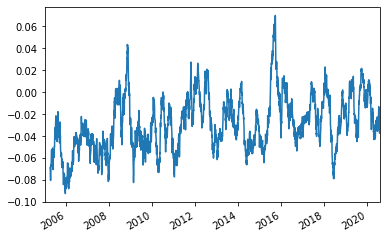

In [358]:
(m1.shift()*y).mean(1).fillna(0).rolling(60).mean().plot()

In [359]:
begin_date = '2017-01-01'
split_date = '2020-01-01'
train_date = y.index[(begin_date < y.index) & (y.index < split_date)]
test_date = y.index[y.index > split_date]

In [360]:
df_y_train = DataFrame({'y':y.loc[train_date, :].values.flatten()})
df_x_train = DataFrame({k:factor[k].loc[train_date, :].shift().values.flatten() for k in factor.keys()})
df_y_test = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test = DataFrame({k:factor[k].loc[test_date, :].shift().values.flatten() for k in factor.keys()})
df_train = pd.concat([df_y_train, df_x_train], axis=1)
df_test = pd.concat([df_y_test, df_x_test], axis=1)

In [369]:
model = smf.ols('y~x1+x2\
                  +z1+z2\
                  +h1+h2+h3\
                  +m1+m2\
                  +gt1+gt2\
                  +peb\
                  +lmv', data=df_train).fit()
model.tvalues

Intercept   -3.221447
x1          -9.197172
x2          -3.212965
z1          -4.477246
z2          -3.012052
h1           6.428519
h2          -1.277482
h3          -5.370401
m1           4.982862
m2          -3.557698
gt1          4.584453
gt2          3.244034
peb         -0.946719
lmv          3.054682
dtype: float64

300497.SZ    0.114980
000739.SZ    0.082448
300003.SZ    0.068388
300267.SZ    0.059635
300006.SZ    0.059624
002755.SZ    0.054854
300482.SZ    0.054575
300595.SZ    0.051772
002950.SZ    0.051155
002044.SZ    0.048682
Name: 2019-12-31 00:00:00, dtype: float64


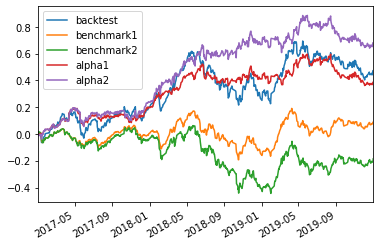

In [370]:
#调仓周期
m = 2
y_hat = DataFrame(model.predict(df_train).values.reshape(len(train_date), len(y.columns)), index=train_date, columns=y.columns)
q = 1 - 3 / len(y_hat.columns)
position = (y_hat.gt(y_hat.quantile(q, 1), 0))

ror_train = ror.loc[train_date, :]
r_rinei_train = r_rinei.loc[train_date, :]
r_geye_train = r_geye.loc[train_date, :]

ror_huice = position * (ror_train.rolling(m).sum().shift(-m+1) - r_geye_train) / m
ror_huice[ror_huice==0] = np.nan
ror_huice.mean(1).cumsum().plot()

benchmark1 = (ror_train.rolling(m).sum().shift(-m+1) - r_geye_train) / m
benchmark1.mean(1).cumsum().plot()
benchmark2 = ror_train
benchmark2.mean(1).cumsum().plot()

alpha1 = ror_huice.mean(1).cumsum() - benchmark1.mean(1).cumsum()
alpha2 = ror_huice.mean(1).cumsum() - benchmark2.mean(1).cumsum()
alpha1.plot()
alpha2.plot()
#for i in industry:
#    stock = industrys[i]
#    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark1', 'benchmark2', 'alpha1', 'alpha2'] + [i for i in industry])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

002603.SZ    0.083066
600867.SH    0.047511
300676.SZ    0.042277
002020.SZ    0.041211
600998.SH    0.039311
300529.SZ    0.038623
002294.SZ    0.038434
002262.SZ    0.036898
002399.SZ    0.035533
600216.SH    0.033234
Name: 2020-07-23 00:00:00, dtype: float64


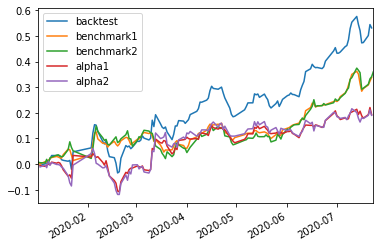

In [371]:
#调仓周期
m = 2
y_hat = DataFrame(model.predict(df_test).values.reshape(len(test_date), len(y.columns)), index=test_date, columns=y.columns)
q = 1 - 3 / len(y_hat.columns)
position = (y_hat.gt(y_hat.quantile(q, 1), 0))

ror_test = ror.loc[test_date, :]
r_rinei_test = r_rinei.loc[test_date, :]
r_geye_test = r_geye.loc[test_date, :]

ror_huice = position * (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m
ror_huice[ror_huice==0] = np.nan
ror_huice.mean(1).cumsum().plot()

benchmark1 = (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m
benchmark1.mean(1).cumsum().plot()
benchmark2 = ror_test
benchmark2.mean(1).cumsum().plot()

alpha1 = ror_huice.mean(1).cumsum() - benchmark1.mean(1).cumsum()
alpha2 = ror_huice.mean(1).cumsum() - benchmark2.mean(1).cumsum()
alpha1.plot()
alpha2.plot()
#for i in industry:
#    stock = industrys[i]
#    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark1', 'benchmark2', 'alpha1', 'alpha2'] + [i for i in industry])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [372]:
position.sum(1)

2020-01-02    0
2020-01-03    3
2020-01-06    3
2020-01-07    3
2020-01-08    3
             ..
2020-07-17    3
2020-07-20    3
2020-07-21    3
2020-07-22    3
2020-07-23    3
Length: 134, dtype: int64

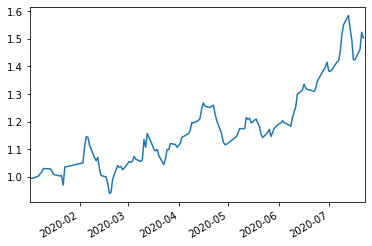

In [373]:
(ror_huice.mean(1)-0.0007+1).cumprod().plot()

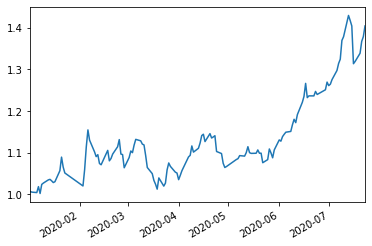

In [366]:
(benchmark2.mean(1)+1).cumprod().plot()

In [367]:
df_y_test2 = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test2 = DataFrame({k:factor[k].loc[test_date, :].values.flatten() for k in factor.keys()})
df_test2 = pd.concat([df_y_test2, df_x_test2], axis=1)
y_hat2 = DataFrame(model.predict(df_test2).values.reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
print(y_hat2.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

002603.SZ    0.047951
300562.SZ    0.038414
000915.SZ    0.038260
002758.SZ    0.036931
002826.SZ    0.036460
002382.SZ    0.036380
603858.SH    0.036357
002950.SZ    0.035705
002044.SZ    0.034732
600771.SH    0.033257
Name: 2020-07-23 00:00:00, dtype: float64


In [368]:
model = RandomForestRegressor(n_estimators=10).fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
model.feature_importances_

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').